In [5]:
#https://www.sbert.net/examples/applications/image-search/README.html
#https://github.com/UKPLab/sentence-transformers/tree/master/examples/applications/image-search/Image_Search.ipynb
#install package Sentence Transformers
!pip install sentence_transformers

  Using cached sentence-transformers-2.0.0.tar.gz (85 kB)
     |████████████████████████████████| 2.8 MB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 58.9 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 895 kB 48.5 MB/s 
     |████████████████████████████████| 3.3 MB 37.5 MB/s 
     |████████████████████████████████| 636 kB 24.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126710 sha256=01c164fbac2812ca26727d7faaf1c6d78c6db64a18285def3769c9b0db9f1169
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#Import of most important packages
import sentence_transformers
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm
torch.set_num_threads(4)

#First, we load the respective CLIP model
model = SentenceTransformer('clip-ViT-B-32')


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [8]:
# Next, we get about 25k images from Unsplash 
img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)
    
    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)
        
    #Extract all images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)
        

  0%|          | 0.00/1.92G [00:00<?, ?B/s]

Extracting:   0%|          | 0/24996 [00:00<?, ?it/s]

In [9]:
# Now, we need to compute the embeddings
# To speed things up, we destribute pre-computed embeddings
# Otherwise you can also encode the images yourself.
# To encode an image, you can use the following code:
# from PIL import Image
# img_emb = model.encode(Image.open(filepath))

use_precomputed_embeddings = True

if use_precomputed_embeddings: 
    emb_filename = 'unsplash-25k-photos-embeddings.pkl'
    if not os.path.exists(emb_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+emb_filename, emb_filename)
        
    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)  
    print("Images:", len(img_names))
else:
    img_names = list(glob.glob('/content/photos/*.jpg'))
    print("Images:", len(img_names))
    img_emb = model.encode([Image.open(filepath) for filepath in img_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

  0%|          | 0.00/51.8M [00:00<?, ?B/s]

Images: 24996


In [10]:
# Next, we define a search function.
#k is number of the best matched images to query
def search2(query, k=3):
    # First, we encode the query (which can either be an image or a text string)
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)
    
    # Then, we use the util.semantic_search function, which computes the cosine-similarity
    # between the query embedding and all image embeddings.
    # It then returns the top_k highest ranked images, which we output
    hits = util.semantic_search(query_emb, img_emb, top_k=k)[0]
    
    print("Query:")
    display(query)
    for hit in hits:
      print(hit['score'], img_names[hit['corpus_id']])
      display(IPImage(os.path.join(img_folder, img_names[hit['corpus_id']]), width=200))
      #return(query, hit['score'], img_names[hit['corpus_id']])


In [11]:
#paste query, which you want to encode and make text-image match
query = 'Presently the tuneful sounds drew near, whereupon she began to fidget, ending by shinning up a tree, just as the dogs burst into view below her, and stifling their songs upon the body of their victim before her eyes—which protruded'

Query:


'It was when I came to this same place with grandma six years ago'

0.2544504404067993 a-vFDVATX-A.jpg


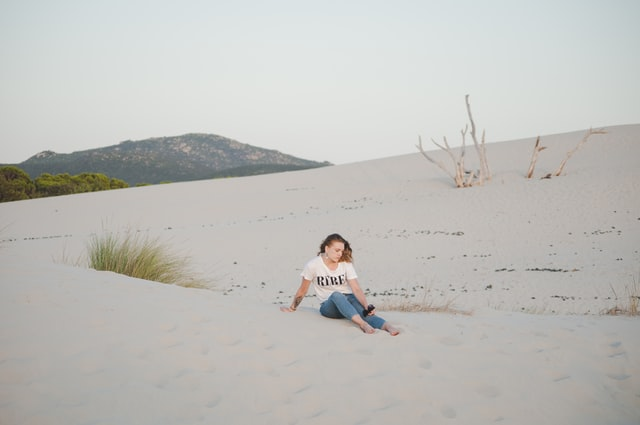

0.24815712869167328 sWw5VwBK1ew.jpg


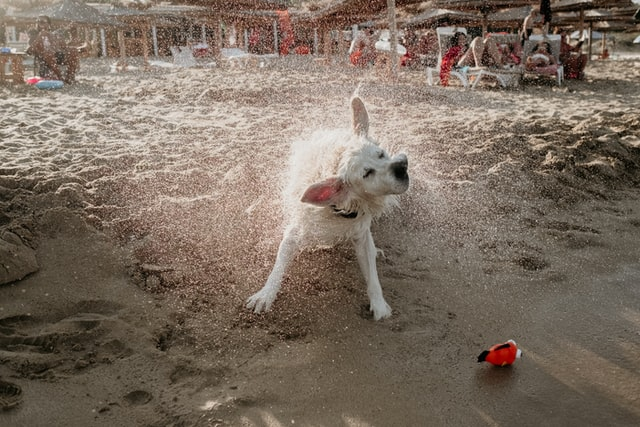

0.24417009949684143 i-oQ_7vTHcE.jpg


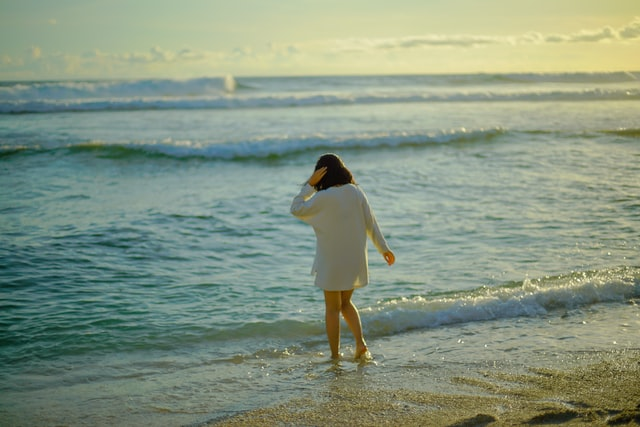

In [12]:
search2('It was when I came to this same place with grandma six years ago')

Query:


'You should always walk straight forward with your toes turned out'

0.27754491567611694 eMDhTAw6Zp4.jpg


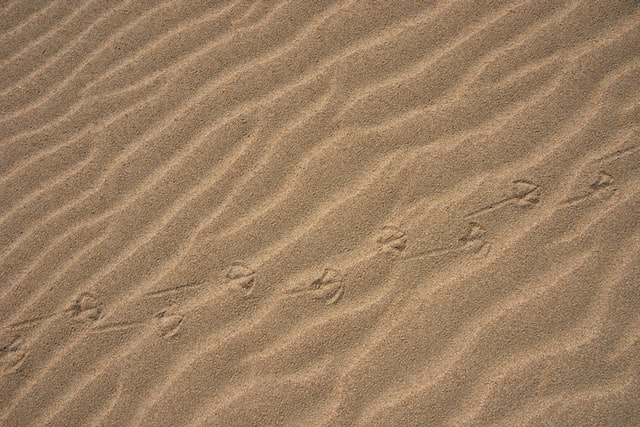

0.2750426232814789 n2LTC8aGPMM.jpg


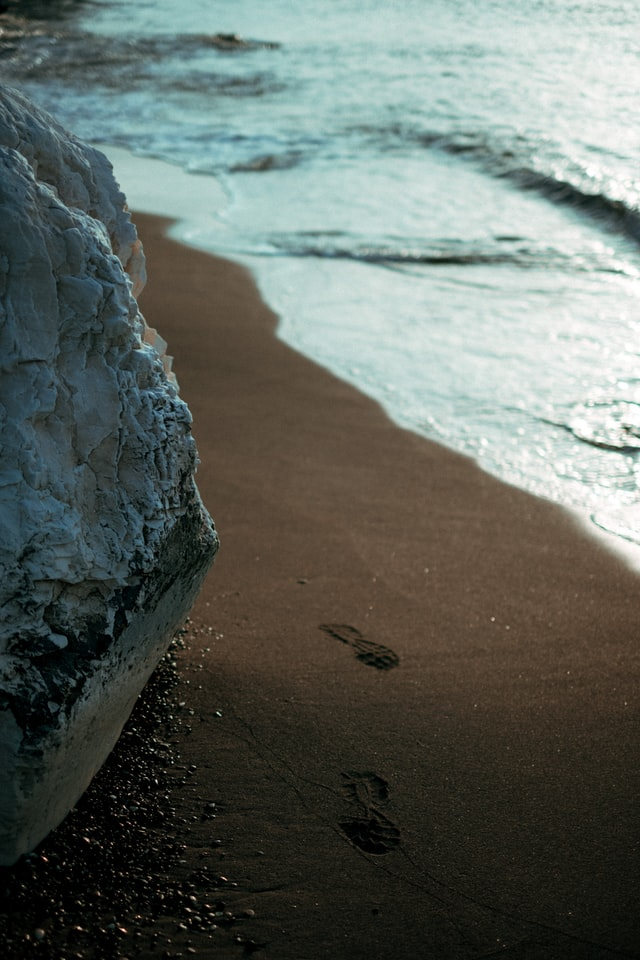

0.2716447710990906 mBtX_MNj3qM.jpg


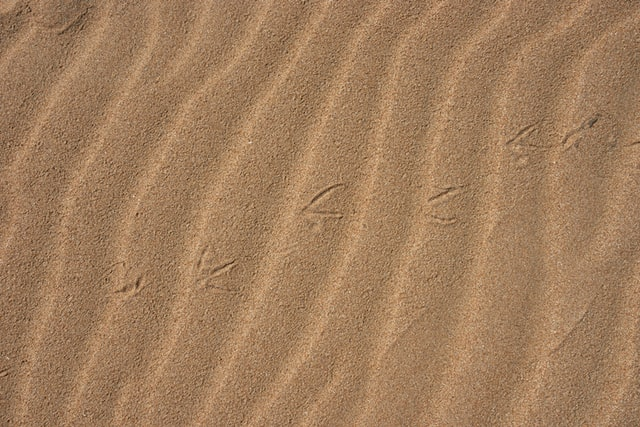

In [13]:
search2('You should always walk straight forward with your toes turned out')

Query:


'Boarders in the same boarding-house and on the same flat are equal to one another.'

0.2585363984107971 upypO_FbRJ4.jpg


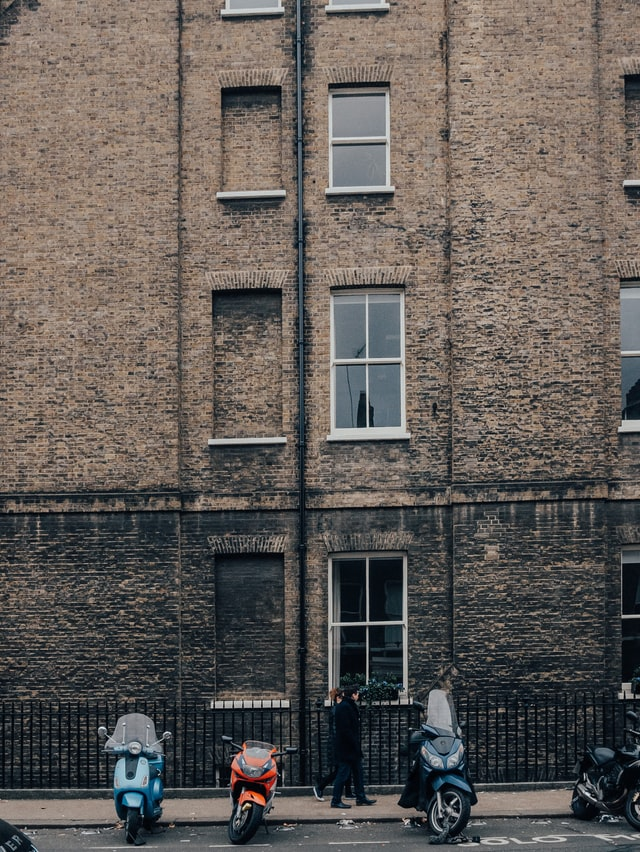

0.2571510672569275 l3GaHpldUs8.jpg


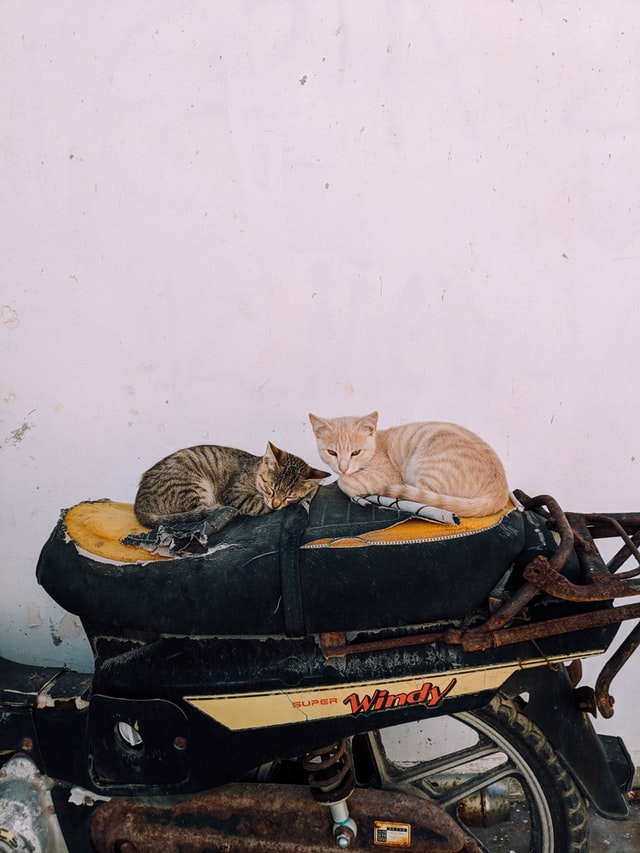

0.2570757269859314 2rYEzFBUenI.jpg


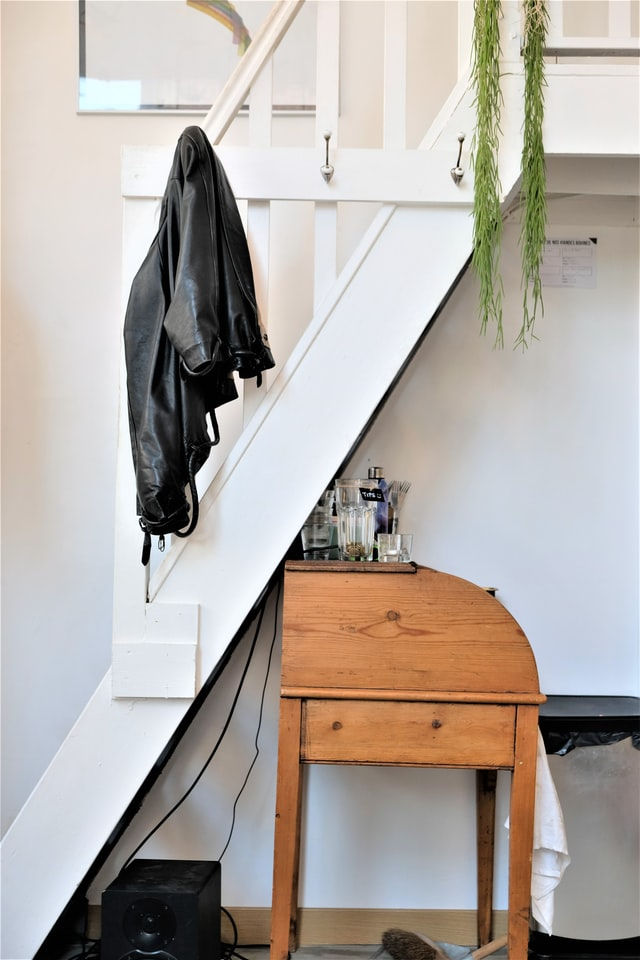

Query:


'The landlady can be reduced to her lowest terms by a series of propositions. '

0.27121105790138245 YbsC9uruhJI.jpg


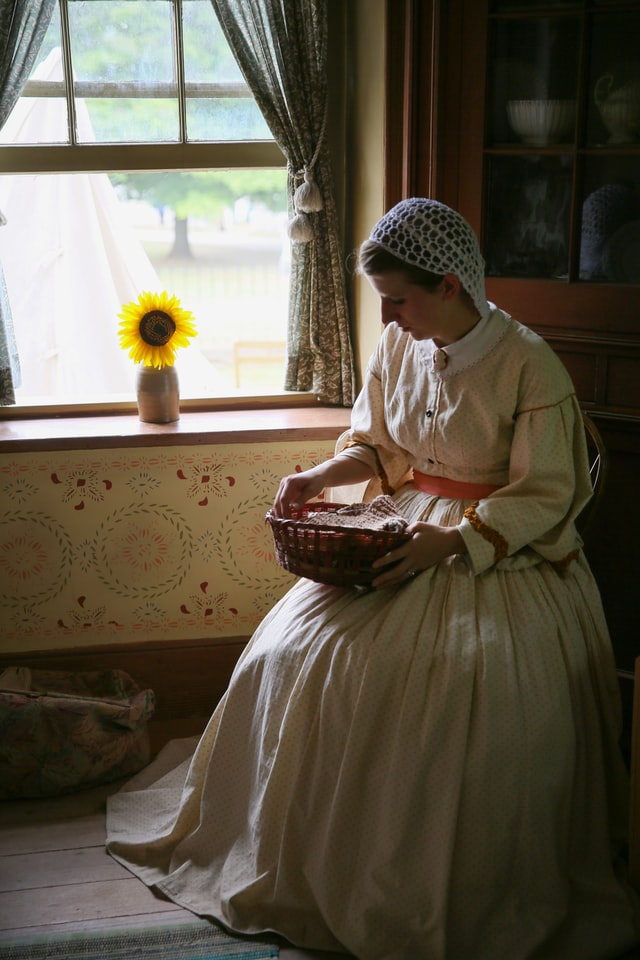

0.2674330174922943 ZrSvGL_13-0.jpg


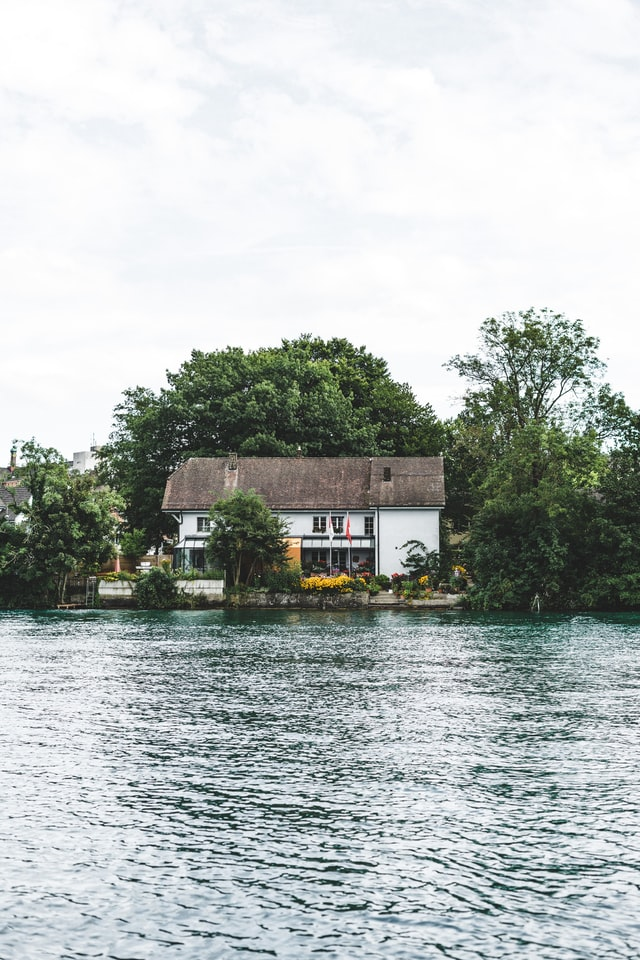

0.2673143148422241 2bS-ZVGcW1g.jpg


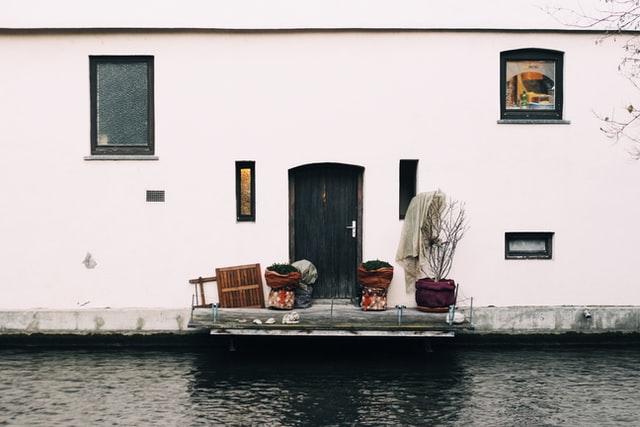

Query:


'Then the other bill is less than it might have been--which is absurd.'

0.23884347081184387 IHWnTa6P7Z0.jpg


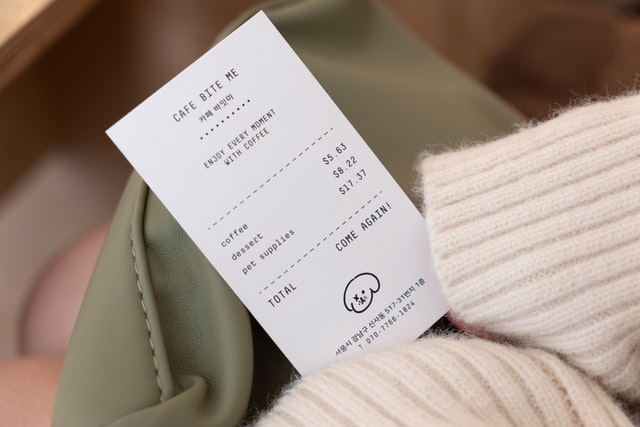

0.2206154763698578 DmOCkOnx-MQ.jpg


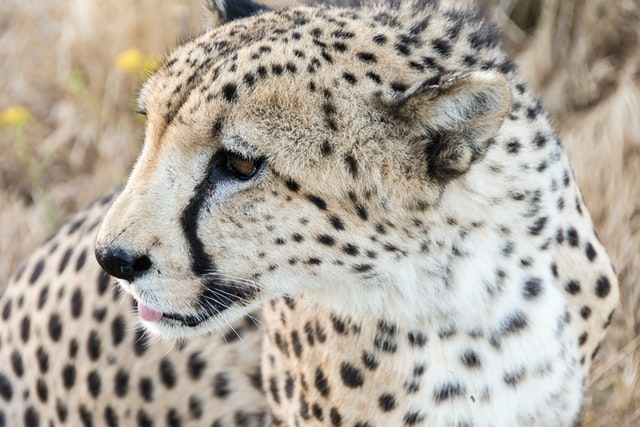

0.21992287039756775 ZCnvMXqa9ho.jpg


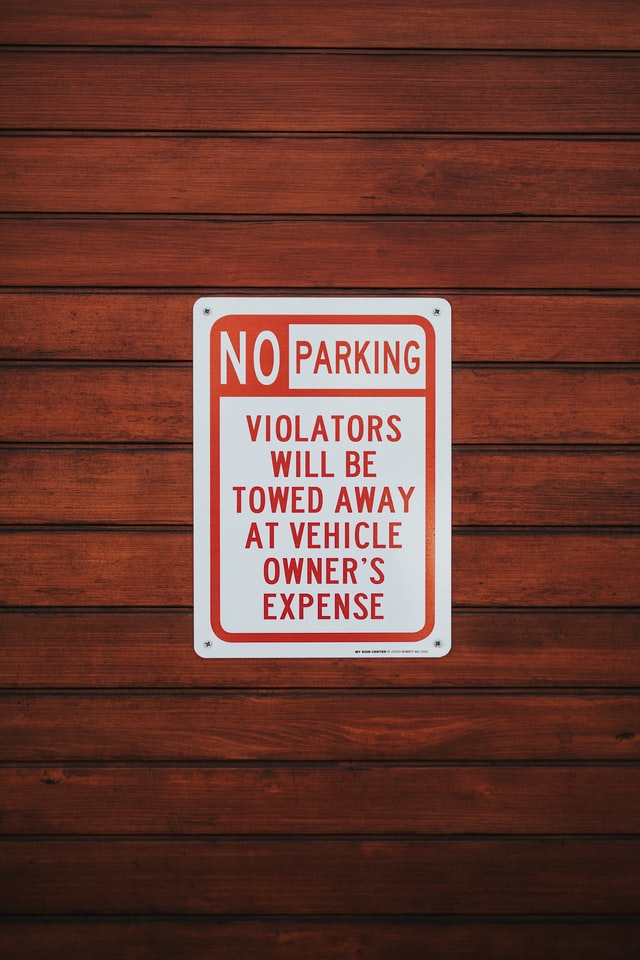

In [15]:
search2("Boarders in the same boarding-house and on the same flat are equal to one another.")
search2("The landlady can be reduced to her lowest terms by a series of propositions. ")
search2("Then the other bill is less than it might have been--which is absurd.")
#search2("If from the opposite ends of a boarding-house a line be drawn passing through all the rooms in turn, then the stovepipe which warms the boarders will lie within that line.")
#search2("What matter if souls and bodies are failing beneath the feet of the ever-pressing multitude!")
#search2("If there be two boarders on the same flat, and the amount of side of the one be equal to the amount of side of the other, each to each, and the wrangle between one boarder and the landlady be equal to the wrangle between the landlady and the other, then shall the weekly bills of the two boarders be equal also, each to each.")
##search2("True, I feel at home in the society of these symbols of life's immutability. ")
#search2("In the procession I should feel the crushing feet, the clashing discords, the ruthless hands and stifling breath.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')